# Exercise 6 - Regression (SLR, MLR, Collinearity)
Using the dataset in EFIplus_medit.zip:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

df = pd.read_csv(os.getcwd() + '\..\..\Examples\EFIplus_medit.zip', compression='zip', sep=";")
df = df.dropna()

## 6.1.
Create a column with the total number of species present (species richness) in each sampling site.

In [27]:
# Find out which columns in the dataframe represent the species.
pd.options.display.max_seq_items = 400
print(df.columns)

Index(['Site_code', 'Latitude', 'Longitude', 'Country', 'Catchment_name',
       'Galiza', 'Subsample', 'Calib_EFI_Medit', 'Calib_connect',
       'Calib_hydrol', 'Calib_morphol', 'Calib_wqual', 'Geomorph1',
       'Geomorph2', 'Geomorph3', 'Water_source_type', 'Flow_regime',
       'Altitude', 'Geological_typology', 'Actual_river_slope',
       'Natural_sediment', 'Elevation_mean_catch', 'prec_ann_catch',
       'temp_ann', 'temp_jan', 'temp_jul', 'Barriers_catchment_down',
       'Barriers_river_segment_up', 'Barriers_river_segment_down',
       'Barriers_number_river_segment_up',
       'Barriers_number_river_segment_down',
       'Barriers_distance_river_segment_up',
       'Barriers_distance_river_segment_down', 'Impoundment', 'Hydropeaking',
       'Water_abstraction', 'Hydro_mod', 'Temperature_impact',
       'Velocity_increase', 'Reservoir_flushing', 'Sedimentation',
       'Channelisation', 'Cross_sec', 'Instream_habitat',
       'Riparian_vegetation', 'Embankment', 'Floodprot

In [30]:
# get index of the column containing the 1st species
col_1st_sp = df.columns.get_loc('Total_sp')+1
print('1st species column:', col_1st_sp)

1st species column: 56


In [35]:
# create the column by counting the columns where at least 1 specimen of the specie was found
df['Species_richness'] = df[df.iloc[:,col_1st_sp:] >= 1].count(axis=1)

*Done. What is represented by column "Total_sp" though?*

In [36]:
print(df[['Total_sp', 'Species_richness']])

      Total_sp  Species_richness
18           5                 6
19           5                 6
28           6                 7
32           7                 8
43           6                 7
...        ...               ...
5006         4                 5
5007         6                 7
5008         5                 6
5009         1                 1
5010         5                 6

[2822 rows x 2 columns]


## 6.2
Run a **simple linear regression** relating the *species richness* with each one of the continuous environmental variables in the dataset: *Altitude, Actual_river_slope, Elevation_mean_catch, prec_ann_catch, temp_ann, temp_jan, temp_jul*.

Before running the analyses, check if any of the variables requires to be transformed and apply the appropriate transformation.

Compute the *regression coefficient estimates*, the *r-square* and the *F-statistics*. You may plot the fitted model.


In [121]:
# subset the df
columns = ['Species_richness', 'Altitude', 'Actual_river_slope', 'Elevation_mean_catch', 'prec_ann_catch', 'temp_ann', 'temp_jan', 'temp_jul']
df2 = df[columns]
df2.head()

,Species_richness,Altitude,Actual_river_slope,Elevation_mean_catch,prec_ann_catch,temp_ann,temp_jan,temp_jul
18,6,1179,0.001,1687.103217,810.092422,9.3,1.4,18.4
19,6,1038,2.258,1293.238318,650.030528,10.4,2.2,19.6
28,7,636,0.263,967.398405,513.949149,12.6,3.8,21.3
32,8,890,2.909,1088.329483,553.756064,11.2,2.7,20.5
43,7,872,3.530,985.273741,518.863081,11.1,2.6,20.0


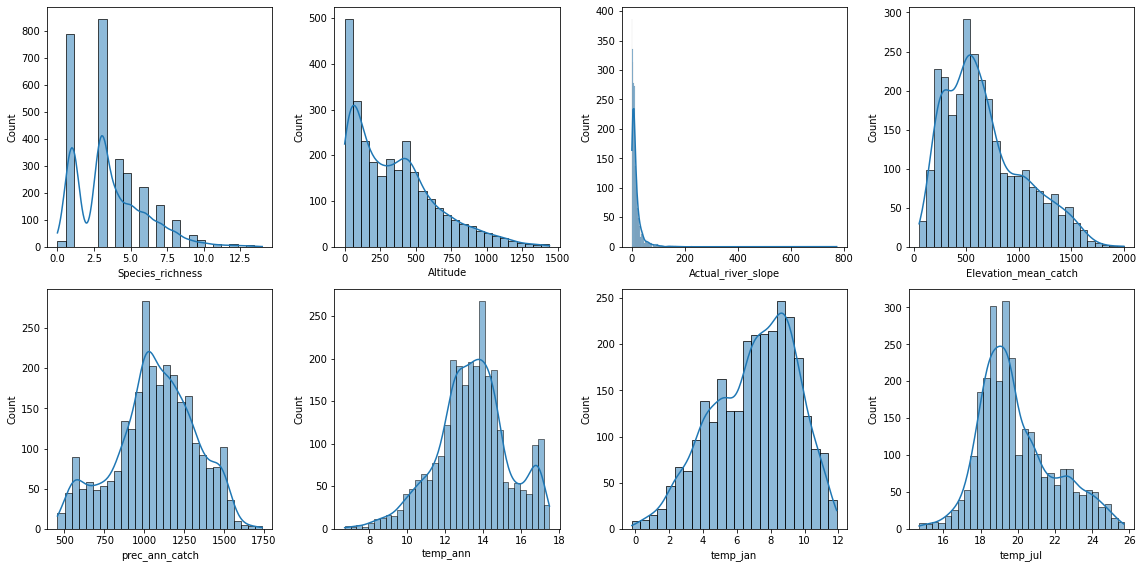

In [122]:
# check if transformation is needed
import seaborn as sns
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))

for i, col in enumerate(columns):
    sns.histplot(df2[col], ax=axes[i//4,i%4], kde=True)

plt.tight_layout()
plt.show()

C:\Users\johan\AppData\Local\Temp\ipykernel_14912\1003355017.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Actual_river_slope'] = np.log10(df2['Actual_river_slope']+1)
C:\Users\johan\AppData\Local\Temp\ipykernel_14912\1003355017.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.rename(columns={'Actual_river_slope': 'log10_Actual_river_slope'}, inplace = True)


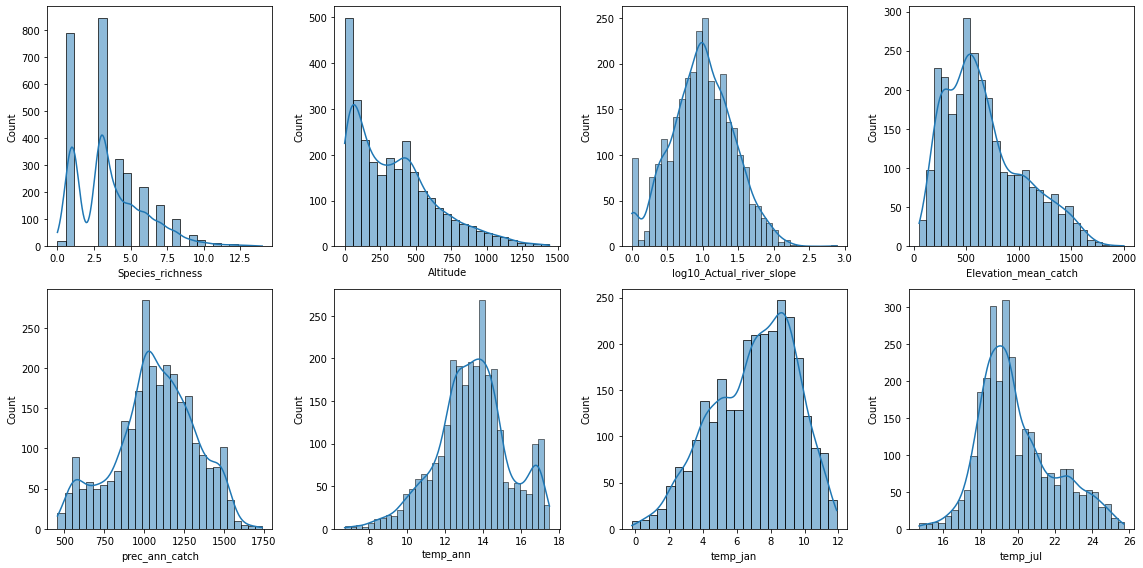

In [123]:
# log transformation for Actual_river_slope
import numpy as np
df2['Actual_river_slope'] = np.log10(df2['Actual_river_slope']+1)
df2.rename(columns={'Actual_river_slope': 'log10_Actual_river_slope'}, inplace = True)
columns = list(df2)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))

for i, col in enumerate(columns):
    sns.histplot(df2[col], ax=axes[i//4,i%4], kde=True)

plt.tight_layout()
plt.show()


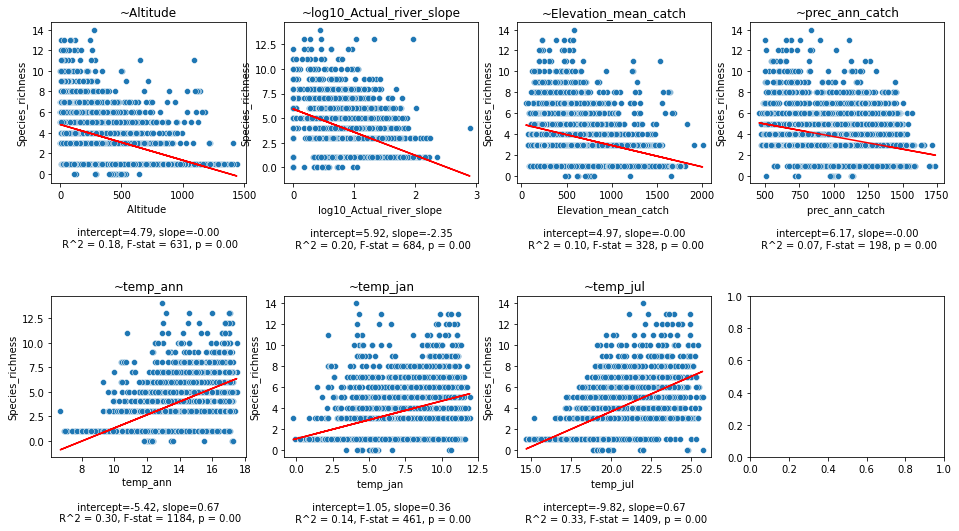

In [124]:
import statsmodels.formula.api as smf

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))

for i, col in enumerate(columns[1:]):
    # Formula: response ~ predictor. Fit the model.
    model = smf.ols(formula = f'Species_richness ~ {col}', data=df2)
    model = model.fit()

    # get the coefficient estimates, R-squared, F-statistics
    est_coeffs = model.params
    R2 = model.rsquared
    F = model.fvalue
    p = model.f_pvalue

    # Generate the predicted values from the fitted model
    predicted = model.predict(df2[col])

    # Plot the original data points and the predicted values
    nrow = i // 4
    ncol = i % 4
    ax = axes[nrow][ncol]
    sns.scatterplot(x = df2[col], y = df2['Species_richness'], ax = ax)
    ax.plot(df2[col], predicted, color='red')
    ax.set_xlabel(f'{col} \n\n intercept={est_coeffs[0]:.2f}, slope={est_coeffs[1]:.2f} \n R^2 = {R2:.2f}, F-stat = {F:.0f}, p = {p:.2f}')
    ax.set_ylabel('Species_richness')
    ax.set_title(f'~{col}')

plt.subplots_adjust(hspace = 0.7)
plt.show()


## 6.3. 
Now try to run a **multiple linear regression** with the same data and check the differences between the previous univariate regression coefficients and the new coefficients.


In [148]:
import statsmodels.api as sm

X = df2[columns[1:]]
y = df2['Species_richness']

X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()

print(f'R^2 = {model.rsquared:.2f}, F-stat = {model.fvalue:}, p = {model.f_pvalue:.2f}')
print(model.summary())

R^2 = 0.41, F-stat = 282.70895272212175, p = 0.00
                            OLS Regression Results                            
Dep. Variable:       Species_richness   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     282.7
Date:                Thu, 04 May 2023   Prob (F-statistic):          9.56e-320
Time:                        18:02:14   Log-Likelihood:                -5672.1
No. Observations:                2822   AIC:                         1.136e+04
Df Residuals:                    2814   BIC:                         1.141e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

*The new coefficients obtained in the MLR differ obviously from the previous univariate regression coefficients, sometimes they do not even have the same sign ( e.g. temp_jan).*

 Plot the partial dependence plots to compare responses with the previous single effects.

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


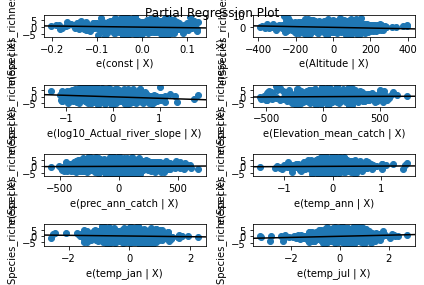

In [179]:
fig = sm.graphics.plot_partregress_grid(model)

## 6.4.
Check the **multicollinearity** among the predictor variables.


*Variance Inflation Factor: measure the degree to which the variance of the estimated regression coefficients is inflated due to multicollinearity.*

*VIF=1 means no multicollinearity, VIF>1 means increasing levels of multicollinearity.*

In [180]:
# Calculate the VIF values for the predictor variables
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Predictor"] = X.columns

# Print the VIF values
print(vif)

          VIF                 Predictor
0  470.916452                     const
1    7.282011                  Altitude
2    1.360411  log10_Actual_river_slope
3    5.886980      Elevation_mean_catch
4    1.475820            prec_ann_catch
5   56.689938                  temp_ann
6   27.180632                  temp_jan
7   14.203277                  temp_jul


Run a second, more parsimonious regression model and check how the coefficients have changed.

*For better model exclude those predictor variables with high levels of multicollinearity.*

In [173]:
X2 = X.drop(['const', 'temp_ann', 'temp_jan', 'temp_jul'], axis=1)
model2 = sm.OLS(y, sm.add_constant(X2)).fit()

coeffs = pd.DataFrame()
coeffs['MLR1']= model.params
coeffs['MLR2'] = model2.params
print(coeffs)

                              MLR1      MLR2
const                    -4.234536  7.290468
Altitude                 -0.002898 -0.003704
log10_Actual_river_slope -1.145903 -1.475389
Elevation_mean_catch      0.000411  0.001066
prec_ann_catch            0.000321 -0.001562
temp_ann                  0.189981       NaN
temp_jan                 -0.271813       NaN
temp_jul                  0.437207       NaN


*Also exclude those predictors that are not statistically significant, i. e. pvalue >0.05:*

In [175]:
X3 = X2.drop(['Elevation_mean_catch', 'prec_ann_catch'], axis=1)
model3 = sm.OLS(y, sm.add_constant(X3)).fit()

coeffs['MLR3'] = model3.params
print(coeffs)

                              MLR1      MLR2      MLR3
const                    -4.234536  7.290468  6.144242
Altitude                 -0.002898 -0.003704 -0.002435
log10_Actual_river_slope -1.145903 -1.475389 -1.727567
Elevation_mean_catch      0.000411  0.001066       NaN
prec_ann_catch            0.000321 -0.001562       NaN
temp_ann                  0.189981       NaN       NaN
temp_jan                 -0.271813       NaN       NaN
temp_jul                  0.437207       NaN       NaN
